# Residuals Analysis


---
**License**

 Residuals Analisis

 Sun Dec 01 11:30:00 2024\
 Copyright  2024\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Ascaso_Extended_Calibration\
 Copyright (C) 2024 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Packages & Configs

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/Ascaso_Extended_Calibration")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

#Calibration functions
from AEC_calibration import RichnessMassRelationCalibration as RMRC
from AEC_corrected_moments import expected_value, standard_deviation

#Useful packages
import numpy as np
from astropy.table import Table

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## Data

### NumCosmo's Matching By Proximity

Data from `cosmoDC2_v1.1.4_image` and `cosmoDC2_v1.1.4_redmapper_v0.8.1` catalogs matched by proximity . See [matching_by_proximity.ipynb](https://github.com/NumCosmo/NumCosmo/blob/ascaso_interface/notebooks/richness_proxy/CatalogsMatching/matching_by_proximity.ipynb)

In [2]:
DC2_rM_mdata = Table.read('CatalogsMatching/match_proximity.fits')
DC2_rM_mdata.rename_column('R', 'richness')
DC2_rM_mdata.rename_column('R_err', 'richness_err')
DC2_rM_mdata.rename_column('z', 'redshift')

### Matching by ID 

Data from `cosmoDC2_v1.1.4_image` and `cosmoDC2_v1.1.4_redmapper_v0.8.1` catalogs matched by ID . See [matching_by_ID.ipynb](https://github.com/NumCosmo/NumCosmo/blob/ascaso_interface/notebooks/richness_proxy/CatalogsMatching/matching_by_ID.ipynb)

In [3]:
# DC2_rM_mdata = Table.read('CatalogsMatching/match_ID.fits')
# DC2_rM_mdata.rename_column('halo_mass', 'mass')

In [4]:
mass_dt = DC2_rM_mdata['mass']
red_dt = DC2_rM_mdata['redshift']
rich_dt = DC2_rM_mdata['richness']

print('Data')
print('\t\tMax \t\t\tMin')
print(f'Mass:\t\t{max(mass_dt):.2e}, \t\t{min(mass_dt):.2e}')
print(f'Redshift:\t{max(red_dt)}, \t{min(red_dt)}')
print(f'Richness:\t{max(rich_dt)}, \t{min(rich_dt)}')


Data
		Max 			Min
Mass:		1.90e+15, 		1.00e+13
Redshift:	1.1764284278635397, 	0.09084865138884513
Richness:	266.2950439453125, 	5.007844924926758


## Models fit

In [6]:
richness_cut = 5.0
rmc = RMRC(DC2_rM_mdata, richness_cut)

### Ascaso Fit Params

Here we do the fitting of linear model parameters using training data in **data_train**. The model is:

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$

$\textbf{p}_{1}$ is the vector with the linear model parameters.


In [16]:
ascaso, fit_ascaso, dmr_asc = rmc.run_fit('ascaso')

lnR_mean_ascaso = rmc.get_mean_model(ascaso, np.log(mass_dt),  red_dt)
lnR_std_ascaso = rmc.get_std_model(ascaso, np.log(mass_dt), red_dt)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1.6094379124341     [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

### Ext (ln(1+z)) Fit Params
Here we do the fitting of quadratic model parameters using training data in **data_train**. Dependence on $\ln (1 + z)$ is considered:

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

$\textbf{p}_{2}$ is the vector with the quadratic model parameters.


In [17]:
ext_ln1pz, fit_ext, dmr_ext = rmc.run_fit('ext_ln1pz')

lnR_mean_ext_ln1pz = rmc.get_mean_model(ext_ln1pz,  np.log(mass_dt),  red_dt)
lnR_std_ext_ln1pz = rmc.get_std_model(ext_ln1pz,  np.log(mass_dt),  red_dt)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

<!-- ### Ext (z) Fit Params

Here we do the fitting of quadratic model parameters using training data in **data_train**. Dependence on $z$ is considered:

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \left(\frac{ z}{z_0}\right) +
    \mu_{z2} \left(\frac{z}{z_0}\right)^2 +
    \mu_{Mz} \left(\frac{z}{z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$ -->

## Errors

Text(0, 0.5, 'Residuals')

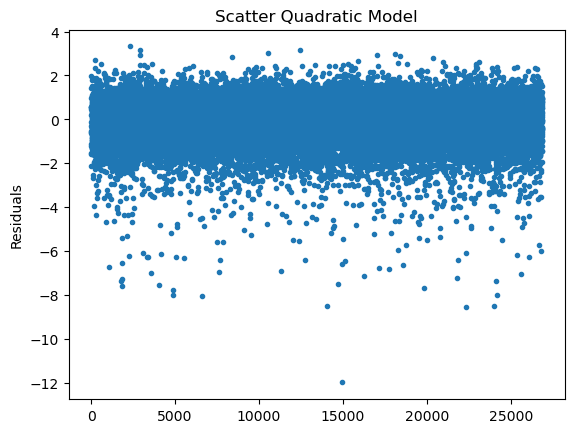

In [58]:
# Res = (lnR_mean_model - lnR_mean_bin) / Std_model

lnR_mean_ext_ln1pz_corrected = expected_value(lnR_mean_ext_ln1pz, lnR_std_ext_ln1pz, richness_cut)
lnR_std_ext_ln1pz_corrected = standard_deviation(lnR_mean_ext_ln1pz, lnR_std_ext_ln1pz, richness_cut)

lnR_mean_ascaso_corrected = expected_value(lnR_mean_ascaso, lnR_std_ascaso, richness_cut)
lnR_std_ascaso_corrected = standard_deviation(lnR_mean_ascaso, lnR_std_ascaso, richness_cut)


residuals_ext = (lnR_mean_ext_ln1pz_corrected  - np.log(rich_dt) )  / lnR_std_ext_ln1pz_corrected
residuals_asc = (lnR_mean_ascaso_corrected - np.log(rich_dt) )  / lnR_std_ascaso_corrected

plt.plot(residuals_ext, '.')
plt.title('Scatter Quadratic Model')
# plt.xlabel('< ln R | M, z > Quadratic')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

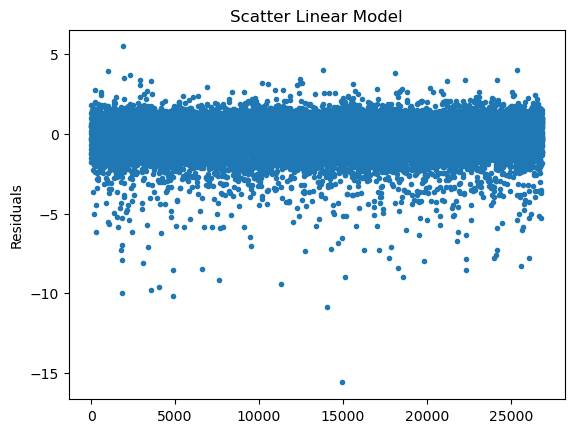

In [53]:
plt.plot( residuals_asc, '.')
# plt.scatter(range(len(residuals_asc)), residuals_asc)
plt.title('Scatter Linear Model')
# plt.xlabel('< ln R | M, z > ascaso ')
plt.ylabel('Residuals')

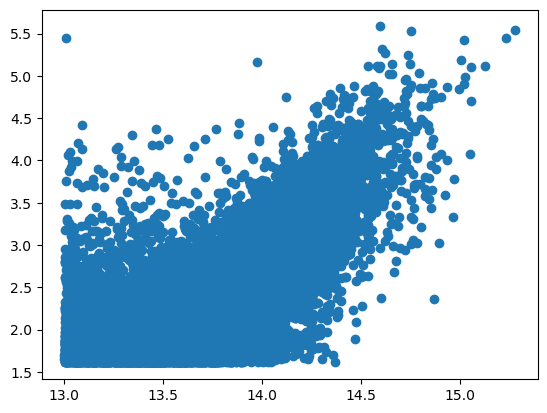

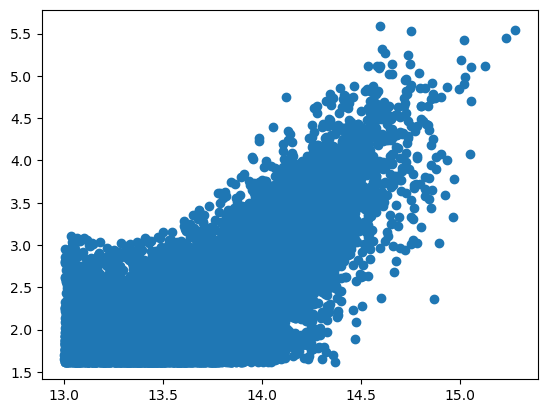

In [60]:
DC2_rM_mdata_cut = DC2_rM_mdata[residuals_ext > -4]

plt.scatter(np.log10(DC2_rM_mdata['mass']), np.log(DC2_rM_mdata['richness']))
plt.show()

plt.scatter(np.log10(DC2_rM_mdata_cut['mass']), np.log(DC2_rM_mdata_cut['richness']))
plt.show()

Text(0.5, 1.0, 'Histogram quadratic Model')

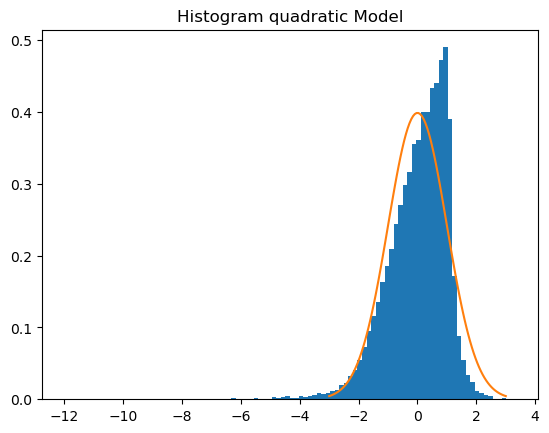

In [54]:
plt.hist(residuals_ext, bins=100, density=True)

x = np.linspace( -3, 3, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1))

plt.title('Histogram quadratic Model')

Text(0.5, 1.0, 'Histogram Linear Model')

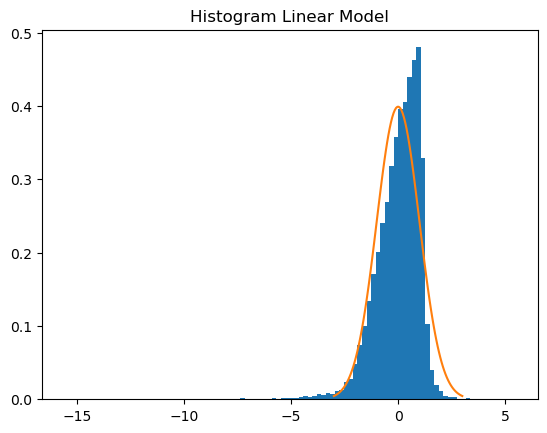

In [55]:
plt.hist(residuals_asc, bins=100, density=True)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.title('Histogram Linear Model')

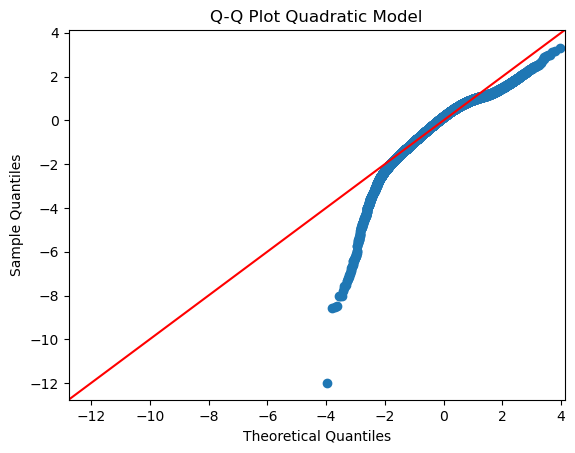

In [56]:
fig = sm.qqplot(residuals_ext, line='45')
plt.title('Q-Q Plot Quadratic Model')
plt.show()

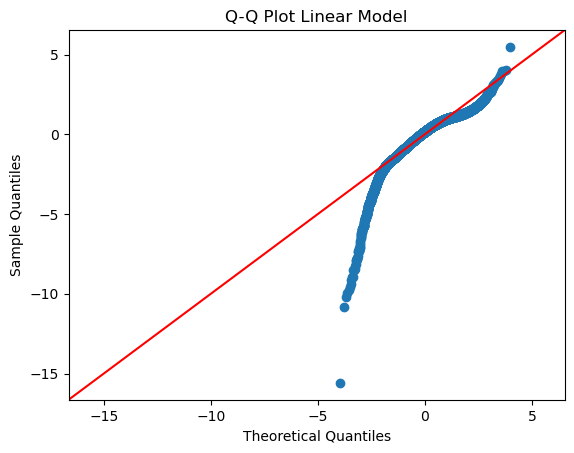

In [57]:
fig = sm.qqplot(residuals_asc, line='45')
plt.title('Q-Q Plot Linear Model')

plt.show()